Columns: ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


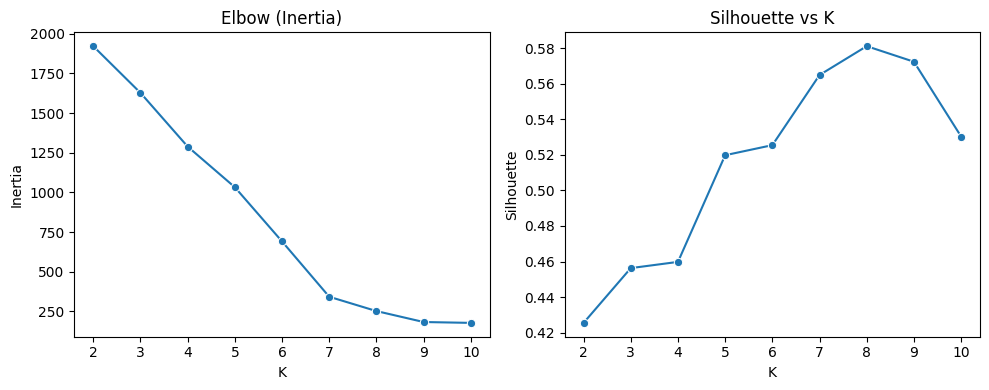

Best K by Silhouette = 8, Silhouette = 0.581
cluster
0     72
1     58
2    106
3     61
4      1
5      7
6      1
7     36
Name: count, dtype: int64


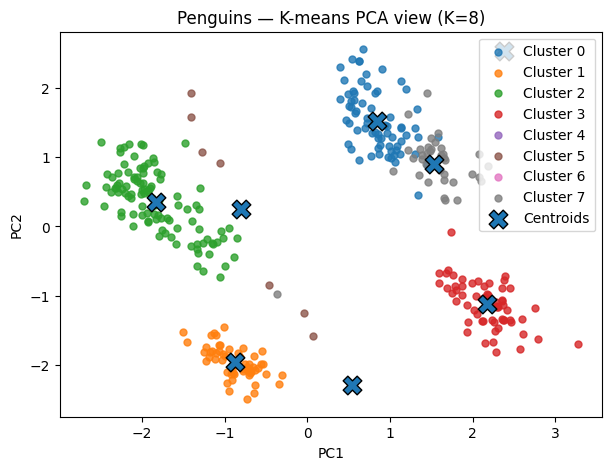

K= 2 | Silhouette=0.426 | Inertia=1922
K= 3 | Silhouette=0.456 | Inertia=1628
K= 4 | Silhouette=0.460 | Inertia=1289
K= 5 | Silhouette=0.520 | Inertia=1033


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Đọc dữ liệu (đổi path nếu cần)
df = pd.read_csv('/kaggle/input/clustering-penguins-species/penguins.csv')  # ví dụ: 'penguins.csv'

# Kiểm tra cột
expected_cols = {'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex'}
missing = expected_cols - set(map(str.lower, df.columns))
print("Columns:", df.columns.tolist())
# Đổi tên cột về dạng nhất quán (nếu file viết hoa/thường lẫn lộn)
df.columns = [c.strip().lower() for c in df.columns]

NUM_COLS = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
CAT_COLS = ['sex']

# Chuẩn hoá giá trị sex và xử lý thiếu
# Cách 1: One-Hot (an toàn khi có giá trị 'Unknown' hoặc NaN)
df['sex'] = df['sex'].astype('string').str.strip().str.title()  # 'Male'/'Female'/nan
df['sex'] = df['sex'].fillna('Unknown')
df = pd.get_dummies(df, columns=CAT_COLS, drop_first=False)   # tạo sex_Female, sex_Male, sex_Unknown

# Loại bỏ hàng thiếu ở cột số (hoặc bạn có thể dùng SimpleImputer)
df = df.dropna(subset=NUM_COLS)

# Ma trận đặc trưng để phân cụm
FEATS = NUM_COLS + [c for c in df.columns if c.startswith('sex_')]
X = df[FEATS].copy()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
inertias, sils = [], []
Ks = range(2, 11)  # K từ 2..10

for k in Ks:
    km = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.lineplot(x=list(Ks), y=inertias, marker='o', ax=ax[0])
ax[0].set_title('Elbow (Inertia)'); ax[0].set_xlabel('K'); ax[0].set_ylabel('Inertia')

sns.lineplot(x=list(Ks), y=sils, marker='o', ax=ax[1])
ax[1].set_title('Silhouette vs K'); ax[1].set_xlabel('K'); ax[1].set_ylabel('Silhouette')

plt.tight_layout(); plt.show()

best_k = list(Ks)[int(np.argmax(sils))]
print(f'Best K by Silhouette = {best_k}, Silhouette = {max(sils):.3f}')
km_final = KMeans(n_clusters=best_k, init='k-means++', n_init='auto', random_state=42)
df['cluster'] = km_final.fit_predict(X_scaled)

print(df['cluster'].value_counts().sort_index())
summary = df.groupby('cluster')[NUM_COLS].agg(['mean','std','min','max','count'])
summary
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_scaled)
centers2 = pca.transform(km_final.cluster_centers_)

plt.figure(figsize=(7,5))
palette = sns.color_palette('tab10', n_colors=best_k)
for c in range(best_k):
    idx = (df['cluster'] == c)
    plt.scatter(X2[idx,0], X2[idx,1], s=25, alpha=0.8, label=f'Cluster {c}', color=palette[c])
plt.scatter(centers2[:,0], centers2[:,1], s=180, marker='X', edgecolor='k', label='Centroids')
plt.title(f'Penguins — K-means PCA view (K={best_k})')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend()
plt.show()
def evaluate_k(k):
    km = KMeans(k, init='k-means++', n_init='auto', random_state=42)
    labels = km.fit_predict(X_scaled)
    return silhouette_score(X_scaled, labels), km.inertia_

for k in [2, 3, 4, 5]:
    s, wcss = evaluate_k(k)
    print(f'K={k:>2} | Silhouette={s:.3f} | Inertia={wcss:.0f}')
